In [1]:
.libPaths("/mnt/home/icb/laura.martens/miniconda3/envs/archr/lib/R/library")
library(Signac)
library(Seurat)

Attaching SeuratObject

Attaching sp



In [2]:
library(Matrix)
library(data.table)
library(stringr)
library(harmony)

Loading required package: Rcpp



In [3]:
library(future)

# Load data

In [4]:
setwd('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/benchmark/neurips/signac/')
matrix <- readMM("../counts.mtx") # read count matrix
matrix <- t(matrix)

peaks <- fread('../peaks.csv', header=TRUE)
rownames(matrix) = peaks$peaks

barcodes <- fread('../barcodes.csv', header=TRUE)
colnames(matrix) = barcodes$barcodes

In [5]:
metadata <- fread('../metadata.csv', header=TRUE)
rownames(metadata) <- barcodes$barcodes

# Get mapping

In [28]:
mapping <- fread('../phase2_to_new_bc_mapping.csv', header=TRUE)
merged_barcodes <- fread('/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix/barcodes.tsv.gz', header=FALSE)

In [36]:
sum(mapping$new_names %in% barcodes$barcodes)

[1] 49231

## Neurips cells

In [62]:
cellnames <- as.data.frame(str_split(mapping[['new_names']], '-', simplify=TRUE))
colnames(cellnames) <- c('barcode', 'sample', 'batch')

cellnames[cellnames[,3] == "",3] <- 's2d4'
cellnames[cellnames[,2] == "s2d4",2] <- '5'

cellnames[['full_barcode']] <- str_c(cellnames[['barcode']],cellnames[['batch']], sep='-')
#cellnames[['alternative']] <- str_c(cellnames[['barcode']],cellnames[['sample']], sep='-')
cellnames[['orig_barcode']] <- mapping[['index']]

In [15]:
#archr cells
cellnames_signac <- as.data.frame(str_split(merged_barcodes$V1, '#|-', simplify=TRUE))
colnames(cellnames_signac) <- c('barcode', 'sample', 'batch')

cellnames_signac[['full_barcode']] <- str_c(cellnames_signac[['barcode']],cellnames_signac[['batch']], sep='-')

In [61]:
not_found <- as.data.frame(str_split(not_found, '#|-', simplify=TRUE))

colnames(not_found) <- c('barcode', 'batch')
table(not_found['batch'])


  12   14 
1749 5978 

In [60]:
not_found <- cellnames[['alternative']][!(cellnames[['alternative']] %in% merged_barcodes[['V1']])]

In [6]:
chrom_assay <- CreateChromatinAssay(
  counts = matrix,
  sep = c(":", "-"),
  genome = 'hg38',
  min.cells = 0,
  min.features = 0,
  fragments = '/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv.gz'
)

Computing hash



ERROR: Error in CreateFragmentObject(path = fragments, cells = cells, validate.fragments = validate.fragments, : Not all cells requested could be found in the fragment file.


In [ ]:
atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data=metadata
)

In [ ]:
atac <- RunTFIDF(atac)
atac <- FindTopFeatures(atac, min.cutoff = 'q0')
atac <- RunSVD(atac)

In [ ]:
DepthCor(atac)

In [9]:
embedding = Embeddings(atac[['lsi']])[,2:30] #remove first component

In [ ]:
write.csv(embedding, file = 'embedding.csv')

In [ ]:
atac <- RunUMAP(object = atac, reduction = 'lsi', dims = 2:30)

In [ ]:
p1 <- DimPlot(object = atac, group.by='batch') 

In [ ]:
p1

## Perform batch correction using harmony

In [23]:
atac <- RunHarmony(
  object = atac,
  group.by.vars = 'batch',
  reduction = 'lsi',
  assay.use = 'peaks',
  project.dim = FALSE
)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 3125050)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [24]:
atac

An object of class Seurat 
116490 features across 62501 samples within 1 assay 
Active assay: peaks (116490 features, 116490 variable features)
 2 dimensional reductions calculated: lsi, harmony

In [37]:
embedding = Embeddings(atac[['harmony']])[,2:30] #remove first component

In [38]:
write.csv(embedding, file = 'embedding_harmony.csv')

In [31]:
atac <- RunUMAP(object = atac, reduction = 'harmony', dims = 2:30)

11:38:32 UMAP embedding parameters a = 0.9922 b = 1.112

11:38:32 Read 62501 rows and found 29 numeric columns

11:38:32 Using Annoy for neighbor search, n_neighbors = 30

11:38:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:38:38 Writing NN index file to temp file /tmp/Rtmpx01ZyB/file45d6e2cc8b1bb

11:38:38 Searching Annoy index using 1 thread, search_k = 3000

11:38:59 Annoy recall = 100%

11:39:00 Commencing smooth kNN distance calibration using 1 thread

11:39:03 Initializing from normalized Laplacian + noise

11:39:07 Commencing optimization for 200 epochs, with 2828076 positive edges

11:40:17 Optimization finished



In [32]:
p2 <- DimPlot(object = atac, group.by='batch') 

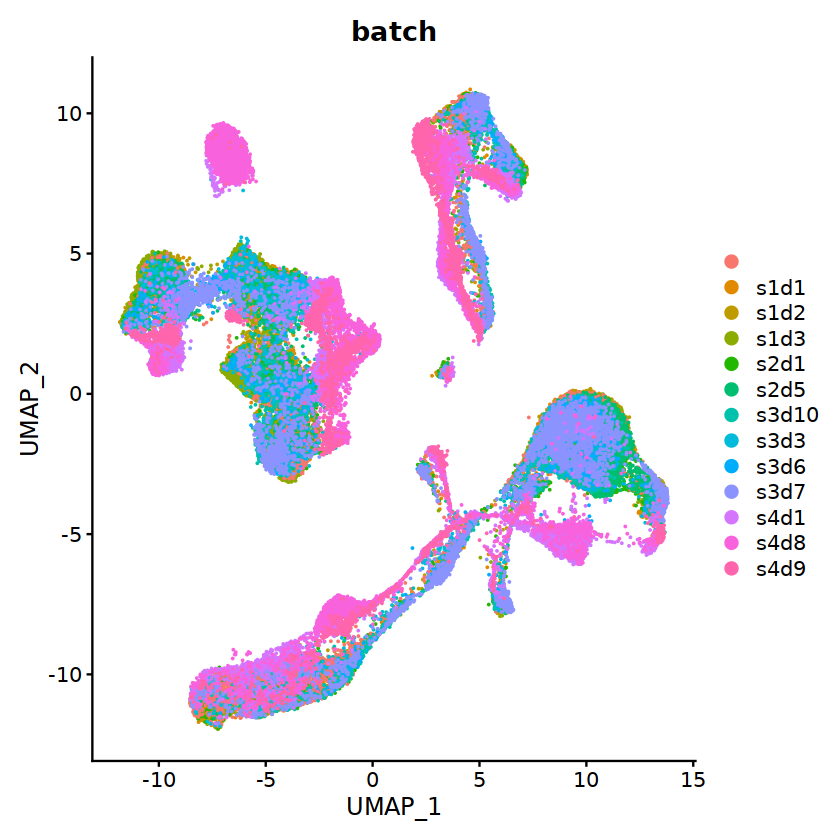

In [35]:
p1

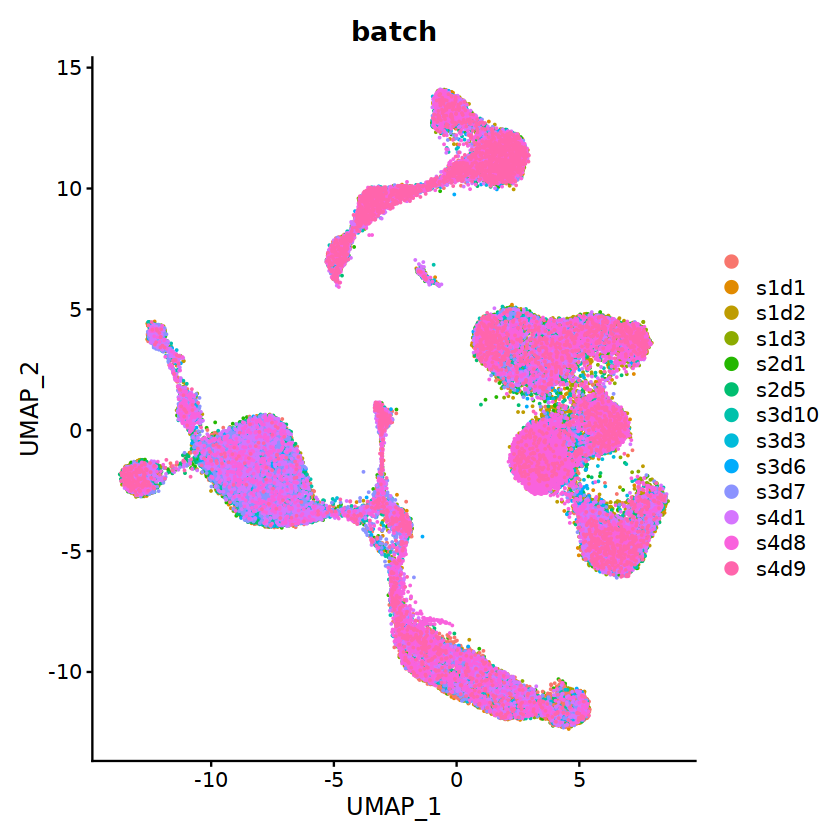

In [36]:
p2

# Differential peaks

## Add gene annotation

In [ ]:
library(EnsDb.Hsapiens.v86)
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

In [ ]:
Annotation(atac) <- annotations

### save data as .rds

In [12]:
saveRDS(atac, file='/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/biological_analysis/da_from_model/neurips_signac.rds')

In [4]:
atac <- readRDS('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/biological_analysis/da_from_model/neurips_signac.rds')

In [21]:
DefaultAssay(atac) <- 'peaks'

In [3]:
library(parallel)
library(MASS)

In [21]:
da_per_cell_type <- function(cell_type){
    print(cell_type)
    plan("multisession")
    da_peaks <- FindMarkers(
      object = atac,
      ident.1 = cell_type,
      test.use = 'LR',
      latent.vars = 'nCount_peaks',
      only.pos=TRUE,
      min.pct=0.05,
      group.by='cell_type',
      verbose=FALSE,
      logfc.threshold = 0,

    )
    write.csv(da_peaks, file = paste0('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/biological_analysis/da_from_model/peak_sets/signac_',cell_type,'.csv'))

}

In [18]:
numCores <- detectCores()
numCores

[1] 96

In [13]:
results <- mclapply(unique(atac[[]]$cell_type), da_per_cell_type, mc.cores = 22)

In [22]:
da_per_cell_type("Normoblast")

[1] "Normoblast"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

## Visualize specific regions

In [6]:
library(EnsDb.Hsapiens.v86)

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:future’:

    values


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:Matrix’:

In [7]:
#BiocManager::install("EnsDb.Hsapiens.v86")

In [12]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objec

In [14]:
# add the gene information to the object
Annotation(atac) <- annotations

In [17]:
library(GenomicRanges)

In [ ]:
chr1 	779026 	779180

In [18]:
region_ofinterest = GRanges(seqnames='chr1', IRanges(779026-2000, 779180+2000))

In [22]:

CoveragePlot(
  object = atac,
region=region_ofinterest,
  extend.upstream = 40000,
  extend.downstream = 20000
)

ERROR: Error in `colnames<-`(`*tmp*`, value = start(x = region):end(x = region)): attempt to set 'colnames' on an object with less than two dimensions


In [20]:
atac

An object of class Seurat 
116490 features across 62501 samples within 1 assay 
Active assay: peaks (116490 features, 116490 variable features)
 1 dimensional reduction calculated: lsi